# Transfer Learning

## Organize files in train and test folders

In [ ]:
# import os
# import shutil
# import numpy as np
# import random 

# if not os.path.isdir('../Data/animal_data/_train') and not os.path.isdir('../Data/animal_data/_test'):
#     folder_path = r"../Data/animal_data/" # Put the path to your dataset
#     ratio_train = .8 # Ratio of images in the train dataset

#     directories = [name for name in os.listdir(folder_path) 
#                 if os.path.isdir(os.path.join(folder_path, name))]

#     #directories.pop(-1)
#     #directories.pop(-1)
#     print(directories)


#     for dir in directories: 
#         print(dir)
#         src_dir = folder_path+dir
#         files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
#         n_files = len(files)
#         train_size = round(ratio_train * n_files)
#         idx_train = random.sample(range(n_files), train_size)
#         idx_test = list(set(range(n_files)) - set(idx_train))
#         dst_dir = folder_path+'_train/'+dir+'/'

#     # Make sure destination folder exists
#         os.makedirs(dst_dir, exist_ok=True)

#     # Loop over selected indices and copy files
#         for idx in idx_train:
#             file_name = files[idx]
#             src_path = os.path.join(src_dir, file_name)
#             dst_path = os.path.join(dst_dir, file_name)
#             shutil.copy(src_path, dst_path)
#         dst_dir = folder_path+'_test/'+dir+'/'

#     # Make sure destination folder exists
#         os.makedirs(dst_dir, exist_ok=True)

#     # Loop over selected indices and copy files
#         for idx in idx_test:
#             file_name = files[idx]
#             src_path = os.path.join(src_dir, file_name)
#             dst_path = os.path.join(dst_dir, file_name)
#             shutil.copy(src_path, dst_path)

In [113]:
from sklearn.model_selection import train_test_split
import os
import shutil
import numpy as np
import random 

def copy_files(src_dir, dst_dir, files):
    # Make sure destination folder exists
    os.makedirs(dst_dir, exist_ok=True)
    # Loop over selected indices and copy files
    for file_name in files:
        #file_name = files[idx]
        src_path = os.path.join(src_dir, file_name)
        dst_path = os.path.join(dst_dir, file_name)
        shutil.copy(src_path, dst_path)

if not os.path.isdir("../Data/animal_data/_train/"): #If already done doesn't do it again
    folder_path = r"../Data/animal_data/" # Put the path to your dataset
    ratio_train = 0.8 # Ratio of images in the train dataset
    ratio_val=0.1 #ratio of images in the validation set in the train set

    directories = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]
    print("Directories:")
    print(directories)


    for dir in directories: 
        print(dir)
        src_dir = folder_path+dir
        files = np.array([f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))])
        
        files_train,files_test=train_test_split(files, train_size=ratio_train)
        files_train,files_val=train_test_split(files_train, test_size=ratio_val)
        
        # n_files = len(files)
        # train_size = round(ratio_train * n_files)
        # idx_train = random.sample(range(n_files), train_size)
        # idx_test = list(set(range(n_files)) - set(idx_train))
        # idx_val= list(set)
        
        #TRAIN
        dst_dir = folder_path+'_train/'+dir+'/'
        copy_files(src_dir, dst_dir, files_train)
        
        #Validation
        dst_dir = folder_path+'_validation/'+dir+'/'
        copy_files(src_dir, dst_dir, files_val)

        #TEST
        dst_dir = folder_path+'_test/'+dir+'/'
        copy_files(src_dir, dst_dir, files_test)

Directories:
['Deer', 'Kangaroo', 'Zebra', 'Dolphin', 'Dog', 'Cat', 'Bear', 'Panda', 'Tiger', 'Giraffe', 'Lion', 'Elephant', 'Cow', 'Horse', 'Bird']
Deer
Kangaroo
Zebra
Dolphin
Dog
Cat
Bear
Panda
Tiger
Giraffe
Lion
Elephant
Cow
Horse
Bird


## Train test split with `flow_from_directory`

In [114]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Train
train_datagen=ImageDataGenerator(
    rotation_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
train_generator=train_datagen.flow_from_directory(
    directory=r"../Data/animal_data/_train/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

# Validation
val_datagen=ImageDataGenerator(rescale=1/255.0)
val_generator=val_datagen.flow_from_directory(
    directory=r"../Data/animal_data/_validation/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

# Test
test_datagen=ImageDataGenerator(
    #rescale=1/255.0
    )
test_generator=test_datagen.flow_from_directory(
    directory=r"../Data/animal_data/_test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 1388 images belonging to 15 classes.
Found 161 images belonging to 15 classes.
Found 395 images belonging to 15 classes.


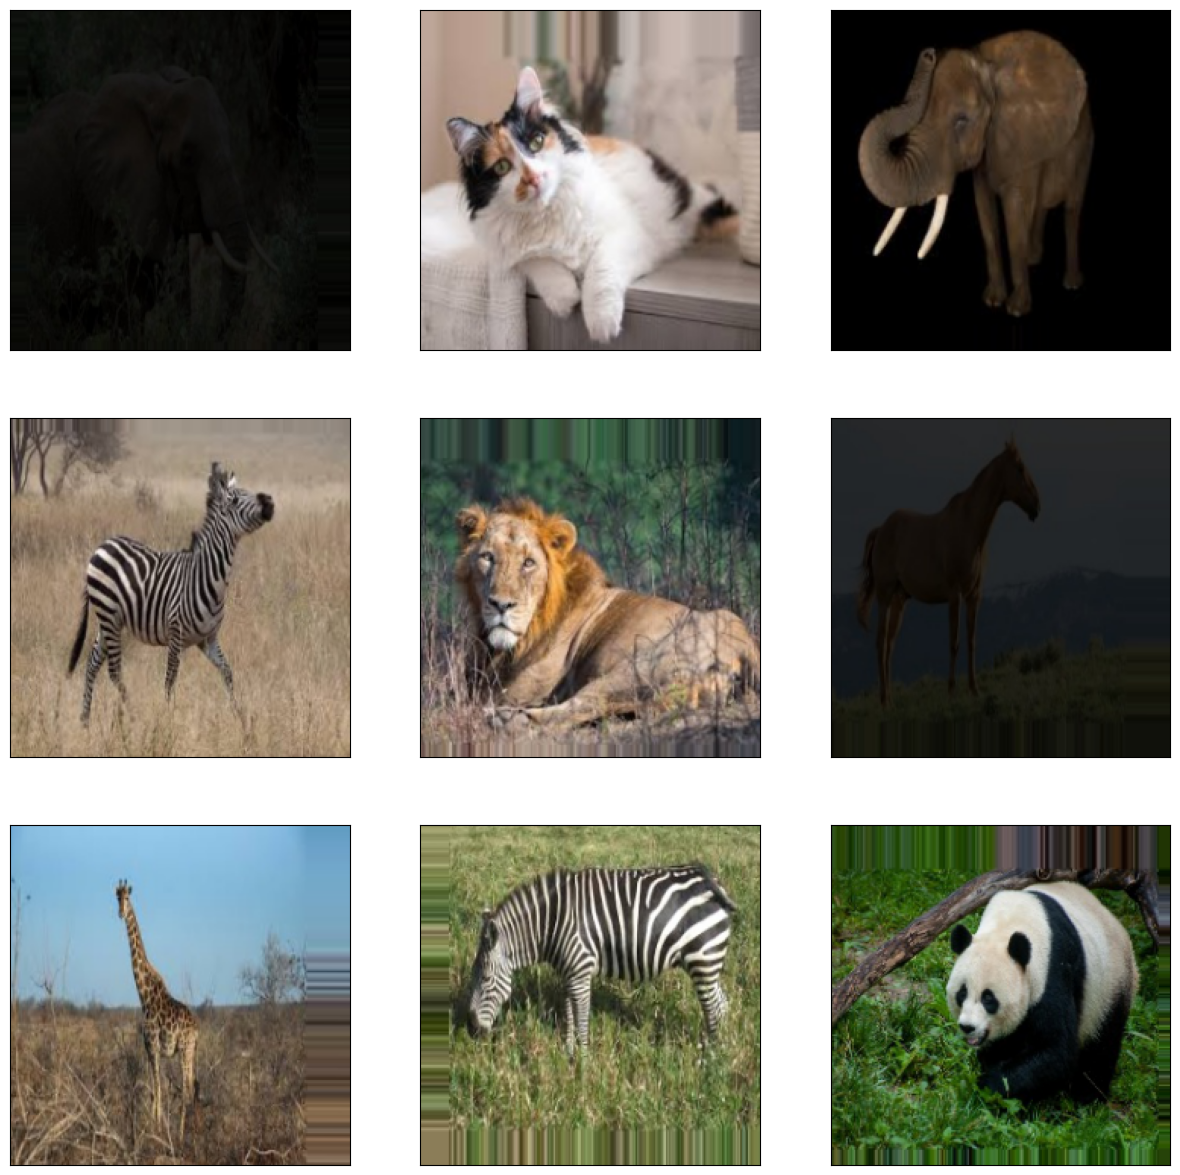

In [115]:
import matplotlib.pyplot as plt

# Visualise some examples
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = next(train_generator)
    imgs = batch[0]
    image = imgs[0].astype('uint8')
    plt.imshow(image)
plt.show()

## First CNN model

In [147]:
from keras import Input
from keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
import numpy as np

modelCNN = Sequential([
    Input(shape=(224,224,3)),
    Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'), 
    MaxPooling2D(pool_size=2),
    Dropout(0.05),
    Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'), 
    MaxPooling2D(pool_size=2),
    Dropout(0.05),
    Flatten(),
    Dense(49, activation='relu'),
    Dropout(0.2),
    Dense(15, activation='softmax')
])

modelCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [148]:
modelCNN.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.0677 - loss: 66.0172 - val_accuracy: 0.0683 - val_loss: 2.7079
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.0706 - loss: 2.7080 - val_accuracy: 0.0683 - val_loss: 2.7079
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.0706 - loss: 2.7080 - val_accuracy: 0.0683 - val_loss: 2.7078
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.0706 - loss: 2.7080 - val_accuracy: 0.0683 - val_loss: 2.7078
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.0706 - loss: 2.7079 - val_accuracy: 0.0683 - val_loss: 2.7078
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.0706 - loss: 2.7080 - val_accuracy: 0.0683 - val_loss: 2.7077
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.0706 - loss: 2.7079 - val_accuracy: 0.0683 - val_loss: 2.7077
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.0706 - loss: 2.7078 - val_accuracy: 0.0683 - 

In [149]:
score_cnn=modelCNN.evaluate(test_generator)[1]

395/395 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.0709 - loss: 2.7055


## Testing pre-trained models 
### VGG-16

In [116]:
from keras.applications.vgg16 import VGG16, decode_predictions
model = VGG16(weights='imagenet')

In [117]:
y_pred_vgg16 = model.predict(test_generator)

/home/julien.dubois@Digital-Grenoble.local/anaconda3/envs/ML5/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


395/395 ━━━━━━━━━━━━━━━━━━━━ 60s 151ms/step


In [118]:
predictions_vgg16 = decode_predictions(y_pred_vgg16)
predicted_classes_vgg16 = []
predicted_prob_vgg16 = []
for pred in predictions_vgg16:
    predicted_classes_vgg16.append(pred[0][1])
    predicted_prob_vgg16.append(pred[0][2])

In [122]:
import collections
unique_pred = collections.Counter(predicted_classes_vgg16)

In [130]:
unique_pred

Counter({'zebra': 27,
         'ice_bear': 14,
         'Egyptian_cat': 13,
         'giant_panda': 12,
         'tiger': 11,
         'stingray': 10,
         'African_elephant': 10,
         'coyote': 9,
         'Saluki': 9,
         'indigo_bunting': 8,
         'Great_Dane': 8,
         'brown_bear': 7,
         'fountain': 7,
         'ox': 7,
         'Weimaraner': 7,
         'tusker': 7,
         'lion': 7,
         'hartebeest': 6,
         'hare': 6,
         'gazelle': 6,
         'American_egret': 5,
         'crane': 5,
         'bittern': 5,
         'mosquito_net': 5,
         'hammerhead': 5,
         'cheetah': 5,
         'whippet': 4,
         'bighorn': 4,
         'impala': 4,
         'bustard': 4,
         'electric_ray': 4,
         'baboon': 3,
         'white_wolf': 3,
         'ostrich': 3,
         'Arabian_camel': 3,
         'English_setter': 3,
         'leatherback_turtle': 3,
         'hyena': 3,
         'starfish': 3,
         'chimpanzee': 3,
      

In [136]:
unique_pred.most_common(3)

[('zebra', 27), ('ice_bear', 14), ('Egyptian_cat', 13)]

### MobileNetV2

In [88]:
from keras.applications import MobileNetV2

model = MobileNetV2(weights='imagenet')
y_pred_mobilenetv2 = model.predict(test_generator)

388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step


In [91]:
from keras.applications.mobilenet_v2 import decode_predictions as decode_predictions_mobilenetv2

predictions_mobilenetv2 = decode_predictions_mobilenetv2(y_pred_mobilenetv2)
predicted_classes_mobilenetv2 = []
predicted_prob_mobilenetv2 = []
for pred in predictions_mobilenetv2:
    predicted_classes_mobilenetv2.append(pred[0][1])
    predicted_prob_mobilenetv2.append(pred[0][2])

In [96]:
import collections
unique_pred_mobilenetv2 = collections.Counter(predicted_classes_mobilenetv2)
unique_pred_mobilenetv2

Counter({'shower_curtain': 306,
         'pillow': 23,
         'window_screen': 20,
         'envelope': 12,
         'lampshade': 5,
         'knot': 4,
         'toilet_tissue': 4,
         'Windsor_tie': 2,
         'bib': 2,
         'pencil_box': 1,
         'iron': 1,
         'spotlight': 1,
         'sea_slug': 1,
         'prayer_rug': 1,
         'spider_web': 1,
         'handkerchief': 1,
         'ant': 1,
         'fire_screen': 1,
         'hook': 1})

## Transfer learning

### VGG16

In [142]:
from keras import Input
from keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in model.layers:
    layer.trainable = False

augmentedVGG16ofthedead = Sequential([
    model,
    Flatten(),
    Dense(15, activation='softmax')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [143]:
from keras.optimizers import SGD

augmentedVGG16ofthedead.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.0001, momentum=0.9), metrics=['accuracy'])

In [144]:
history_augmentedVGG16ofthedead = augmentedVGG16ofthedead.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 173s 4s/step - accuracy: 0.5713 - loss: 9.1480 - val_accuracy: 0.4410 - val_loss: 2.0131
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.8646 - loss: 2.4644 - val_accuracy: 0.4410 - val_loss: 1.8487
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.9287 - loss: 1.1799 - val_accuracy: 0.3975 - val_loss: 2.0079
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 164s 4s/step - accuracy: 0.9280 - loss: 1.1801 - val_accuracy: 0.4907 - val_loss: 1.7561
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - accuracy: 0.9510 - loss: 0.8029 - val_accuracy: 0.5031 - val_loss: 1.8126
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.9553 - loss: 0.4872 - val_accuracy: 0.4534 - val_loss: 1.8968
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.9676 - loss: 0.3643 - val_accuracy: 0.4348 - val_loss: 1.8611
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 164s 4s/step - accuracy: 0.9798 - loss: 0.2604 - val_accuracy: 0.3665 - v

In [145]:
score_augmented = augmentedVGG16ofthedead.evaluate(test_generator)[1]

395/395 ━━━━━━━━━━━━━━━━━━━━ 43s 109ms/step - accuracy: 0.9316 - loss: 1.7331
93.2% : Augmented VGG16


In [150]:
print(f"{score_cnn*100:.1f}% : My CNN")
print(f"{score_augmented*100:.1f}% : Augmented VGG16")

7.1% : My CNN
93.2% : Augmented VGG16
